# Estimation of MET cross section with Madgraph 3.6.2

## Import MG5 and dependencies

In [231]:
import os
import sys
sys.path.append('../src') # Only if madpy is not installed
MADGRAPH_PATH = f"../mg5amcnlo"
sys.path.append(MADGRAPH_PATH)


## Install models and plugins

### [DMSimp](https://feynrules.irmp.ucl.ac.be/wiki/DMsimp)
- https://feynrules.irmp.ucl.ac.be/wiki/DMsimp 


Simplified DM extension with a scalar mediator and three DM candidates

- PDG number 5000001 to particle xr
- PDG number 51 to particle xc
- PDG number 52 to particle xd
- PDG number 54 to particle y0

- PDG number 9000001 to particle ghA
- PDG number 9000002 to particle ghZ
- PDG number 9000003 to particle ghWp
- PDG number 9000004 to particle ghWm
- g ghg ghg~ u c d s b u~ c~ d~ s~ b~ a gha gha~ ve vm vt e- mu- ve~ vm~ vt~ e+ mu+ t t~ z w+ ghz ghwp ghwm h xr xc y0 w- ghz~ ghwp~ ghwm~ xc~ ta- xd ta+ xd~

In [232]:

import subprocess
from subprocess import Popen, PIPE, CalledProcessError

def madpy_generate_script(process: str = "p p > t t~ j",
                          model: str = "sm",
                          masses: dict | None = {"mt": "scan:[190, 200]"},
                          coupling: dict | None = None,
                          decays: dict | None = {"wt": "Auto"},
                          pt_cut: dict | None = {"ptj": "40"},
                          madspin: bool = True,
                          number_events: int = 1000,
                          script_file_name: str = "new_process.mg5",
                          workdir_path: str = "../workdir",
                          process_dir: str = "new_process",
                          coupled_scan: bool = True,
                          draw_diagrams: bool = True):
    
    workdir_process = f"{workdir_path}/{process_dir}"
    
    mg5_script = f"""\
import model sm
import model {model}
generate {process}
output {workdir_process} -f
display diagrams
launch {workdir_process}"""
    
    if masses:
        for particle, mass in masses.items():
            mg5_script += "\n\t" + f"""set mass {particle} {mass}"""
            
    if coupling:
        for coup, value in coupling.items():
            mg5_script += "\n\t" + f"""set DMINPUTS {coup} {value}"""
    
    if decays:
        for decay, value in decays.items():
            mg5_script += "\n\t" + f"""set width {decay} {value}"""
    
    if pt_cut:
        for pt, cut in pt_cut.items():
            mg5_script +=  "\n\t" + f"""set {pt} {cut}"""
    
    # if madspin:
    #     mg5_script += "\n\t" + f"""madspin=ON"""
    
    # else:
    #     mg5_script += "\n\t" + f"""madspin=OFF"""
        
    # Set number of events
    
    # Set Energy Beam

    mg5_script += "\n\t" + f"""set run_card bwcutoff = 150"""
    mg5_script += "\n\t" + f"""set run_card ebeam1 = 1500"""
    mg5_script += "\n\t" + f"""set run_card ebeam2 = 1500"""
    mg5_script += "\n\t" + f"""set run_card lpp1 = 0"""
    mg5_script += "\n\t" + f"""set run_card lpp2 = 0"""
    mg5_script += "\n\t" + f"""set nevents {number_events}"""
    # mg5_script += "\n\t" + f"""set run_card pdfset = NNPDF31_lo_as_0118"""
    #mg5_script += "\n\t" + f"""set run_card pta = 60"""      # minimum pt for the photons 
    #mg5_script += "\n\t" + f"""set run_card ptamax = 1000"""   # maximum pt for the photons 
    # set scale

    # if madspin:
    #     mg5_script += "\n\t" + f"""madspin=ON"""
    
    # else:
    #     mg5_script += "\n\t" + f"""madspin=OFF"""
    
    
    with open(script_file_name, "w") as script_file:
        script_file.write(mg5_script)
        
    return mg5_script, script_file_name
    
def madpy_run(mg5_script_path: str, mg5_bin: str = "mg5_aMC", madgraph_path = MADGRAPH_PATH):
    
    mg5_executable = f"{madgraph_path}/bin/{mg5_bin}"
    subprocess.run([mg5_executable, mg5_script_path])



#*********************************************************************
# Collider type and energy                                           *
# lpp: 0=No PDF, 1=proton, -1=antiproton,                            *
#                2=elastic photon of proton/ion beam                 *
#             +/-3=PDF of electron/positron beam                     *
#             +/-4=PDF of muon/antimuon beam                         *
#*********************************************************************
    #  1        = lpp1    ! beam 1 type 
    #  1        = lpp2    ! beam 2 type
#          6500.0     = ebeam1  ! beam 1 total energy in GeV
#      6500.0     = ebeam2  ! beam 2 total energy in GeV
# # To see polarised beam options: type "update beam_pol"

In [233]:
# Generate script
import numpy as np
Mmed_mass = np.arange(500, 4500, 100)
mx_mass = Mmed_mass / 3 

str(list(mx_mass))

'[166.66666666666666, 200.0, 233.33333333333334, 266.6666666666667, 300.0, 333.3333333333333, 366.6666666666667, 400.0, 433.3333333333333, 466.6666666666667, 500.0, 533.3333333333334, 566.6666666666666, 600.0, 633.3333333333334, 666.6666666666666, 700.0, 733.3333333333334, 766.6666666666666, 800.0, 833.3333333333334, 866.6666666666666, 900.0, 933.3333333333334, 966.6666666666666, 1000.0, 1033.3333333333333, 1066.6666666666667, 1100.0, 1133.3333333333333, 1166.6666666666667, 1200.0, 1233.3333333333333, 1266.6666666666667, 1300.0, 1333.3333333333333, 1366.6666666666667, 1400.0, 1433.3333333333333, 1466.6666666666667]'

In [234]:

## Parameters
workdir_path = "../workdir"
process_name =  "e+ e- > y0 > $ xd xd~"
model =  "eDMsimp_s_spin0"
script_file_name = "dm_process_ee.mg5"
process_dir = "dmsimp_ee_v1"
masses_dict = {"mxd": f"scan1:{str(list(mx_mass))}",
               "my0": f"scan1:{str(list(Mmed_mass))}",}
number_events = 1000
sm_coupling_value = 0.25
dm_coupling_value = 1.0
decays = {"9000001": "Auto",
        "9000002": "Auto",
        "9000003": "Auto",
        "9000004": "Auto"}
decays = None
# dm_coup_list = ['gsxr', "gsxc", 'gsxd', 'gpxd']
# sm_coup_list = ["gsd11", "gsu11", "gsd22", "gsu22", "gsd33", "gsu33", "gpd11", "gpu11", "gpd22",
#                 "gpu22", "gpd33", "gpu33", "gsg", "gpg", "gsh1", "gsh2", "gsb", "gpb", "gsw", "gpw"]
dm_coup_list = ['gSXd', "gSXc ", 'gsxr']
sm_coup_list = ["gSe"]

sm_coup_dict = dict(zip(sm_coup_list, [sm_coupling_value for _ in range(len(sm_coup_list))]))
dm_coup_dict = dict(zip(dm_coup_list, [dm_coupling_value for _ in range(len(dm_coup_list))]))
coups_dict = sm_coup_dict | dm_coup_dict # update the dict


In [235]:
full_script_str, mg5_script_path = madpy_generate_script(process = process_name,
                                                        model = model,
                                                        script_file_name = script_file_name,
                                                        process_dir= process_dir,
                                                        masses = masses_dict,
                                                        coupling = coups_dict,
                                                        decays = decays,
                                                        pt_cut = None,
                                                        madspin = False, ## For e+e-, madspin = False 
                                                        number_events = number_events,
                                                         )


In [236]:

madpy_run(mg5_script_path)

************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.6.3                 2025-06-12         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

Command "import /home/mjrxy/MadPy/notebooks/dm_process_ee.mg5" interrupted in sub-command:
"generate e+ e- > y0 > $ xd xd~" with error:
InvalidCmd : Empty or wrong format process, please try again.


In [237]:
import pandas as pd
workdir_process = f"{workdir_path}/{process_dir}"
# load the file
df = pd.read_csv(
    workdir_process + '/Events/scan_run_[01-40].txt',
    sep='\s+',
)

In [238]:
df

,#run_name,mass#53,mass#54,cross,error
0,run_01,166.6667,500.0,0.055862,6.750600e-11
1,run_02,200.0000,600.0,0.056822,1.251200e-10
2,run_03,233.3333,700.0,0.057998,2.303000e-10
3,run_04,266.6667,800.0,0.059414,1.223700e-10
4,run_05,300.0000,900.0,0.061103,3.315100e-10
5,run_06,333.3333,1000.0,0.063104,2.377600e-10
6,run_07,366.6667,1100.0,0.065466,1.952800e-10
7,run_08,400.0000,1200.0,0.068254,3.717400e-10
8,run_09,433.3333,1300.0,0.071552,3.326000e-10
9,run_10,466.6667,1400.0,0.075468,3.317400e-10


In [239]:
df.rename(columns={"mass#53":"m_f", "mass#54":"M_med"}, inplace=True)
df 

,#run_name,m_f,M_med,cross,error
0,run_01,166.6667,500.0,0.055862,6.750600e-11
1,run_02,200.0000,600.0,0.056822,1.251200e-10
2,run_03,233.3333,700.0,0.057998,2.303000e-10
3,run_04,266.6667,800.0,0.059414,1.223700e-10
4,run_05,300.0000,900.0,0.061103,3.315100e-10
5,run_06,333.3333,1000.0,0.063104,2.377600e-10
6,run_07,366.6667,1100.0,0.065466,1.952800e-10
7,run_08,400.0000,1200.0,0.068254,3.717400e-10
8,run_09,433.3333,1300.0,0.071552,3.326000e-10
9,run_10,466.6667,1400.0,0.075468,3.317400e-10


In [240]:
df['cross'] = df['cross'] * 1E3 # Convert pb -> fb
df['m_f'] = df['m_f'] / 1000 # GeV -> TeV
df['M_med'] = df['M_med'] / 1000 # GeV -> TeV

In [ ]:
df

,#run_name,m_f,M_med,cross,error
0,run_01,0.166667,0.5,55.862,6.750600e-11
1,run_02,0.200000,0.6,56.822,1.251200e-10
2,run_03,0.233333,0.7,57.998,2.303000e-10
3,run_04,0.266667,0.8,59.414,1.223700e-10
4,run_05,0.300000,0.9,61.103,3.315100e-10
5,run_06,0.333333,1.0,63.104,2.377600e-10
6,run_07,0.366667,1.1,65.466,1.952800e-10
7,run_08,0.400000,1.2,68.254,3.717400e-10
8,run_09,0.433333,1.3,71.552,3.326000e-10
9,run_10,0.466667,1.4,75.468,3.317400e-10


In [197]:
df.to_pickle('/home/mjrxy/resonant-scalar-madg/notebooks/mg5_results_ee.pkl')

In [12]:
import matplotlib.pyplot as plt

def plot_columns(df, x_col, y_col, xlabel=None, ylabel=None, title=None):
    """
    Plot a scatter plot of two columns from a pandas DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the data.
    x_col : str
        Name of the column to use for the x-axis.
    y_col : str
        Name of the column to use for the y-axis.
    xlabel : str, optional
        Custom label for the x-axis. Defaults to column name.
    ylabel : str, optional
        Custom label for the y-axis. Defaults to column name.
    title : str, optional
        Title of the plot.
    """
    plt.figure(figsize=(7, 5))
    plt.scatter(df[x_col], df[y_col], s=50, alpha=0.7, edgecolor="k")

    plt.xlabel(xlabel if xlabel else x_col)
    plt.ylabel(ylabel if ylabel else y_col)
    plt.yscale('log')
    if title:
        plt.title(title)

    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

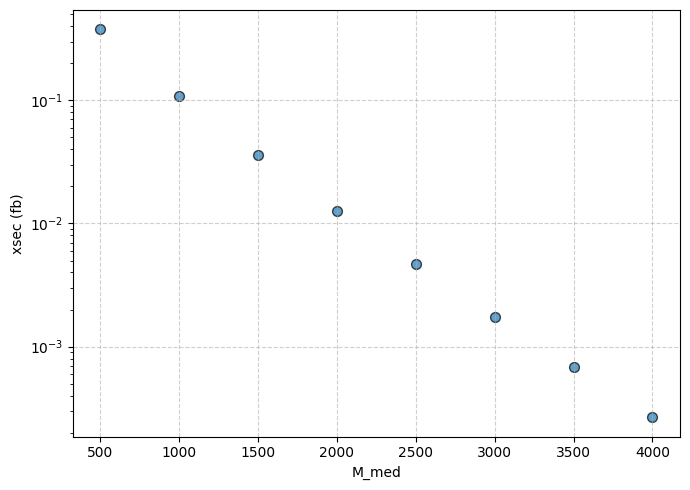

In [13]:
plot_columns(df, 'M_med', "cross", xlabel='M_med', ylabel="xsec (fb)")

In [58]:
workdir_process = f"{workdir_path}/{process_dir}"
with open(workdir_process + '/Events/scan_run_0[1-9].txt', "r") as file:
    lines = file.readlines()

In [60]:
[line.strip(" ") for line in lines]

['#run_name            mass#52              mass#54              cross                error                width#9000002        width#9000003        width#9000004        \n',
 'run_01               5.000000e+02         1.500000e+03         4.788800e-05         2.713600e-07         0.000000e+00         0.000000e+00         0.000000e+00         \n',
 'run_02               5.000000e+02         2.500000e+03         1.111600e-05         5.670700e-08         0.000000e+00         0.000000e+00         0.000000e+00         \n',
 'run_03               5.000000e+02         3.500000e+03         2.019800e-06         1.207600e-08         0.000000e+00         0.000000e+00         0.000000e+00         \n',
 'run_04               8.333333e+02         1.500000e+03         9.327200e-08         7.674700e-10         0.000000e+00         0.000000e+00         0.000000e+00         \n',
 'run_05               8.333333e+02         2.500000e+03         7.603300e-06         3.629500e-08         0.000000e+00      

In [ ]:
# Read diagrams
import glob
from IPython.display import Image, display

diagram_files = sorted(glob.glob("myHiggsProc/HTML/diagram*.png"))

for f in diagram_files:
    display(Image(filename=f))

## Read info from generated files

### Unpack lhe files

In [65]:
import subprocess
import os
import pandas as pd
#import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

lhe_file = '/home/mjrxy/MadPy/workdir/new_process/Events/run_01/unweighted_events.lhe.gz'

def unpack_events(events_path):
    try:
        #output_zip_file = os.path.join(working_dir, f"{event_name}/Events/run_01/unweighted_events.lhe.gz")
        subprocess.run(["gzip", "-d", events_path])
        print("Arquivo LHE descompactado com sucesso.")
    except FileNotFoundError:
        print('Arquivo ja foi descompactado')

unpack_events(lhe_file)

Arquivo LHE descompactado com sucesso.


In [ ]:
import subprocess
import os
import pandas as pd
#import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MG_VERSION = "v3_6_2"

import subprocess
import os
import pandas as pd
#import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

lhe_file = '/home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_01/unweighted_events.lhe.gz'
def unpack_events(events_path):
    # Caminho para o arquivo de saída com eventos gerados
    output_file = events_path # os.path.join(working_dir, f"{event_name}/Events/run_01/unweighted_events.lhe")
    try:
        #output_zip_file = os.path.join(working_dir, f"{event_name}/Events/run_01/unweighted_events.lhe.gz")
        subprocess.run(["gzip", "-d", "-k", output_file])
        print("Arquivo LHE descompactado com sucesso.")
        
        return events_path.strip(".gz")
    except FileNotFoundError:
        print('Arquivo ja foi descompactado')

lhe_file = '/home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_01/unweighted_events.lhe.gz'
output_lhe_file = unpack_events(lhe_file)


Arquivo LHE descompactado com sucesso.


gzip: /home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_01/unweighted_events.lhe already exists;	not overwritten


In [71]:
output_lhe_file

'/home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_01/unweighted_events.lhe'

In [101]:
# Extract cross section from LHE file
def get_cross_section(lhe_file):
    cross_section = None
    with open(lhe_file, 'r') as file:
        in_init_block = False
        for line in file:
            if "<init>" in line:
                in_init_block = True
            elif "</init>" in line:
                in_init_block = False
                break
            elif in_init_block:
                data = line.strip().split()
                if len(data) <= 6:
                    cross_section = float(data[0]) 
                    error = float(data[1])
                    break
    return cross_section, error

# Extract the events and convert it to pandas format
def parse_lhe_file(file_path, cross_section, error, run_number=None):
    events = []
    event_id = 0

    with open(file_path, 'r') as file:
        in_event = False
        for line in file:
            if "<event>" in line:
                in_event = True
                event = []
                event_id += 1  # Incrementa o ID do evento a cada novo evento
            elif "</event>" in line:
                in_event = False
                events.append(event)
            elif in_event:
                data = line.strip().split()
                if len(data) >= 6:
                    try:
                        particle_data = list(map(float, data))
                        particle_data.append(event_id)  # Adiciona o ID do evento à partícula
                        event.append(particle_data)
                    except ValueError:
                        #print("line ", line)
                        #print("event id ", event_id)
                        #print('particle data ', particle_data)
                        #print('error in line ', data)
                        pass


                        # TODO: How to extract this info 
                        # <mgrwt>
                        # <rscale>  0 0.43702855E+04</rscale>
                        # <asrwt>0</asrwt>
                        # <pdfrwt beam="1">  1        2 0.25919763E+00 0.43702855E+04</pdfrwt>
                        # <pdfrwt beam="2">  1       -2 0.32749606E+00 0.43702855E+04</pdfrwt>
                        # <totfact> 0.16864895E-01</totfact>
                        # </mgrwt>

            
    # Converte a lista de eventos para um DataFrame
    columns = ["pid", "status", "m_mother1", "mother2", "color1", "color2", "px", "py", "pz", "E", "M", "lifetime", "spin", "event_id"]
    df = pd.DataFrame([item for sublist in events for item in sublist], columns=columns)
    # Adiciona uma coluna de cross-section (mesmo valor para todos os eventos)
    df["cross_section"] = cross_section #pb
    df["cross_section_error"] = error #± pb
    df.dropna(subset=["lifetime", "spin"], inplace=True)
    
    if run_number:
        df['run_number'] = run_number
        

    return df, events

# Extraia a cross-section do arquivo LHE
cross_section_value, cross_section_error = get_cross_section(output_lhe_file)
print(f'Cross section of the run: {cross_section_value} pb +/- {cross_section_error} pb' )


Cross section of the run: 9.71148e-06 pb +/- 3.517785e-08 pb


In [102]:
df_events_merged = pd.DataFrame()
lhe_file = '/home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_01/unweighted_events.lhe.gz'
output_lhe_file = unpack_events(lhe_file)
for run in [1, 2, 3, 4]:
    lhe_file = f'/home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_0{run}/unweighted_events.lhe.gz'
    output_lhe_file = unpack_events(lhe_file)
    
    df_events, _ = parse_lhe_file(output_lhe_file, cross_section_value, cross_section_error, run_number=run)
    df_events_merged = pd.concat([df_events_merged, df_events])


gzip: /home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_01/unweighted_events.lhe already exists;	not overwritten
gzip: /home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_01/unweighted_events.lhe already exists;	not overwritten
gzip: /home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_02/unweighted_events.lhe.gz: No such file or directory
gzip: /home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_03/unweighted_events.lhe already exists;	not overwritten


Arquivo LHE descompactado com sucesso.
Arquivo LHE descompactado com sucesso.
Arquivo LHE descompactado com sucesso.
Arquivo LHE descompactado com sucesso.
Arquivo LHE descompactado com sucesso.


gzip: /home/mjrxy/MadPy/workdir/dmsimp_v1/Events/run_04/unweighted_events.lhe already exists;	not overwritten


In [103]:
df_events_merged

,pid,status,m_mother1,mother2,color1,color2,px,py,pz,E,M,lifetime,spin,event_id,cross_section,cross_section_error,run_number
1,2.0,-1.0,0.0,0.0,501.0,0.0,0.000000,0.000000,1943.982226,1943.982226,0.0000,0.0,1.0,1.0,0.00001,3.517785e-08,1
2,-2.0,-1.0,0.0,0.0,0.0,501.0,-0.000000,-0.000000,-2456.220443,2456.220443,0.0000,0.0,-1.0,1.0,0.00001,3.517785e-08,1
3,54.0,2.0,1.0,2.0,0.0,0.0,612.476625,-894.719000,-34.397685,3215.305509,3026.7733,0.0,0.0,1.0,0.00001,3.517785e-08,1
4,52.0,1.0,3.0,3.0,0.0,0.0,1054.075517,638.417402,556.966260,1441.826408,500.0000,0.0,1.0,1.0,0.00001,3.517785e-08,1
5,-52.0,1.0,3.0,3.0,0.0,0.0,-441.598892,-1533.136402,-591.363945,1773.479101,500.0000,0.0,1.0,1.0,0.00001,3.517785e-08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6511,-2.0,-1.0,0.0,0.0,0.0,501.0,-0.000000,0.000000,2201.177140,2201.177140,0.0000,0.0,-1.0,1000.0,0.00001,3.517785e-08,4
6512,2.0,-1.0,0.0,0.0,501.0,0.0,0.000000,-0.000000,-3408.418752,3408.418752,0.0000,0.0,1.0,1000.0,0.00001,3.517785e-08,4
6513,52.0,1.0,1.0,2.0,0.0,0.0,146.051217,-1244.666732,-1615.490473,2535.810659,1500.0000,0.0,1.0,1000.0,0.00001,3.517785e-08,4
6514,-52.0,1.0,1.0,2.0,0.0,0.0,-901.409811,1194.358992,-163.605877,2125.041160,1500.0000,0.0,1.0,1000.0,0.00001,3.517785e-08,4


### Subtitles for the PIDs

In [ ]:
import pandas as pd


## TODO: Refactor this table with DM particles


# Criação da tabela de referência de partículas
particle_data = {
    "PID": [11, -11, 13, -13, 22, 12, -12, 14, -14, 16, -16, 1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 21, 23, 24, -24],
    "Name": [
        "Electron", "Positron", "Muon", "Anti-Muon", "Photon",
        "Electron Neutrino", "Electron Anti-Neutrino", "Muon Neutrino", "Muon Anti-Neutrino",
        "Tau Neutrino", "Tau Anti-Neutrino", "Down Quark", "Anti-Down Quark",
        "Up Quark", "Anti-Up Quark", "Strange Quark", "Anti-Strange Quark",
        "Charm Quark", "Anti-Charm Quark", "Bottom Quark", "Anti-Bottom Quark",
        "Gluon", "Z Boson", "W+ Boson", "W- Boson"
    ],
    "Symbol": [
        "e-", "e+", "mu-", "mu+", "a",
        "ve", "ve~", "vm", "vm~",
        "vt", "vt~", "d", "d~",
        "u", "u~", "s", "s~",
        "c", "c~", "b", "b~",
        "g", "z", "w+", "w-"
    ]
}

# Criação do DataFrame com as informações de partículas
particle_df = pd.DataFrame(particle_data)
particle_df.to_csv('particle_names.csv', index=False)
print(particle_df)

In [104]:
total_cross_section = df_events.cross_section.iloc[0] * 1000 # converts to fb
total_cross_section_error = df_events.cross_section_error.iloc[0]
print(total_cross_section, total_cross_section_error)

0.00971148 3.517785e-08


In [ ]:
# TODO: Merge this repository with the scalar DM analysis
# TODO: Put this repository inside SPRACE [?]
# TODO: Get equivalent cross section points for analytical results with mono photon.
# TODO: Get results for those same parameters, for relic density as well (MadDM and Analytical)

## Plotting the mg5 / lhe results

In [ ]:

## Filter neutrino events


# df_events['neutrino'] = 1
# df_events['neutrino'] = -1
# df_events.loc[df_events['PID'].isin([12, 14, 16, ]), 'neutrino'] = True
# df_events.loc[df_events['PID'].isin([-12, -14, -16]), 'anti_neutrino'] = True
# #df_events.loc[df_events['neutrino'], 'PID'] = 12
# #df_events['PID_abs'] = abs(df_events['PID'])
# df_gp = df_events.groupby(['Event_ID', 'neutrino' ,'PID'], as_index=False)['E'].sum()


In [ ]:
import mplhep as hep
# ZZ, a pair of heavier bosons.

def get_hist_bins(df_to_plot, bin_gev):
    
    gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
    M_hist = np.histogram(df_to_plot, bins=gev_bin) #range=(rmin, rmax))
    # the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions
    hist, bins = M_hist  # hist=frequency ; bins=Mass values
    return hist, bins
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy()
hist1, bins1 = get_hist_bins(df_to_plot, 10)
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy()

hist1, bins1 = get_hist_bins(df_to_plot, 10)
fig, ax = plt.subplots(figsize=(10, 5))
bin_gev = 5

hep.histplot(
    [hist1, hist1],
    bins=bins1,
    histtype="fill",
    stack=True,
    color=["b", "r"],
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Events / {bin_gev} GeV", fontsize=15)
#ax.set_xlim(rmin, rmax)
ax.legend()
fig.show()


In [ ]:

# ZZ, a pair of heavier bosons.
## converts to cross section
df_to_plot = df_gp.loc[df_gp['PID'].isin([12]), 'E'].to_numpy() 
bin_gev = 0.1
#gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
M_hist = np.histogram(df_to_plot, bins=10000) #range=(rmin, rmax))
# the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions


hist, bins = M_hist  # hist=frequency ; bins=Mass values
fig, ax = plt.subplots(figsize=(10, 5))
hist = hist * total_cross_section /1000000
hep.histplot(
    hist,
    bins=bins,
    histtype="fill",
    color="b",
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Cross Section $\sigma$ (fb) ", fontsize=15)
ax.set_yscale('log')
ax.legend()
fig.show()


In [22]:
hist_df = pd.DataFrame(M_hist).T.rename(columns={0: 'nevents', 1: 'energy_nu'})

In [23]:
hist_df['xsec'] = hist_df['nevents'] * total_cross_section /1000000

In [24]:
hist_df['integrated_xsec'] = 0
xsec_met = {}
for energy in range(1000, 6000, 100):
    xsec_met[energy] = hist_df.loc[hist_df['energy_nu'].between(energy, energy+100), 'xsec'].sum()


In [25]:
energy_xsec_df = pd.DataFrame.from_dict(xsec_met, orient='index', columns=['xsec_met']).reset_index().rename(columns={'index': 'energy_nu'}) 

In [26]:
energy_xsec_df.to_csv('energy_met_xsec.csv', index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
hist = hist * total_cross_section /1000000
ax.plot(energy_xsec_df['energy_nu'], energy_xsec_df['xsec_met'])
ax.set_xlabel(r"$\nu_l \bar \nu_l$ (MET) energy (GeV)", fontsize=15)
ax.set_ylabel(f"Cross Section $\sigma$ (fb) ", fontsize=15)
ax.set_yscale('log')
ax.legend()
fig.show()

In [ ]:
import mplhep as hep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

hep.style.use("CMS")
# ZZ, a pair of heavier bosons.
df_to_plot = df_gp.loc[df_gp['PID'].isin([22]), 'E'].to_numpy()
df_to_plot
bin_gev = 100
gev_bin = abs(int((df_to_plot.max() - df_to_plot.min())  / bin_gev)) # Gev
M_hist = np.histogram(df_to_plot, bins=gev_bin) #range=(rmin, rmax))
# the tuple `M_hist` that this function gives is so common in python that it is recognized by mplhep plotting functions

hist, bins = M_hist  # hist=frequency ; bins=Mass values
fig, ax = plt.subplots(figsize=(10, 5))
hep.histplot(
    hist,
    bins=bins,
    histtype="fill",
    color="y",
    alpha=0.5,
    edgecolor="black",
    label=rf"""$pp \to \gamma \nu_\ell \bar \nu_\ell$ 
    $\sigma = {total_cross_section}$ fb""",
    ax=ax,
)

ax.set_xlabel(r"$\gamma$ energy (GeV)", fontsize=15)
ax.set_ylabel(f"Events / {bin_gev} GeV", fontsize=15)
#ax.set_xlim(rmin, rmax)
ax.legend()
fig.show()


In [ ]:
df_gp.loc[df_gp['PID'].isin([12]), 'E'].hist(bins=50)#.set_xlim(1000, 1500)


(1000.0, 1500.0)

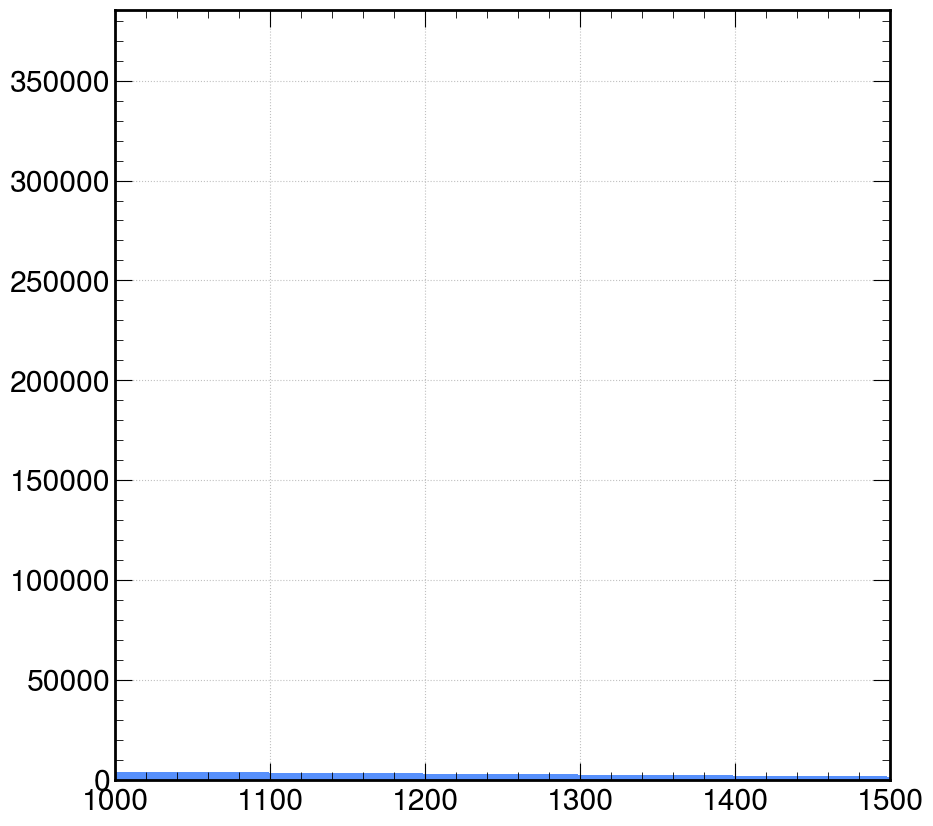

In [32]:
df_events.loc[df_events['PID'].isin([12, -12]), 'E'].hist(bins=50).set_xlim(1000, 1500)

array([[<Axes: title={'center': 'E'}>]], dtype=object)

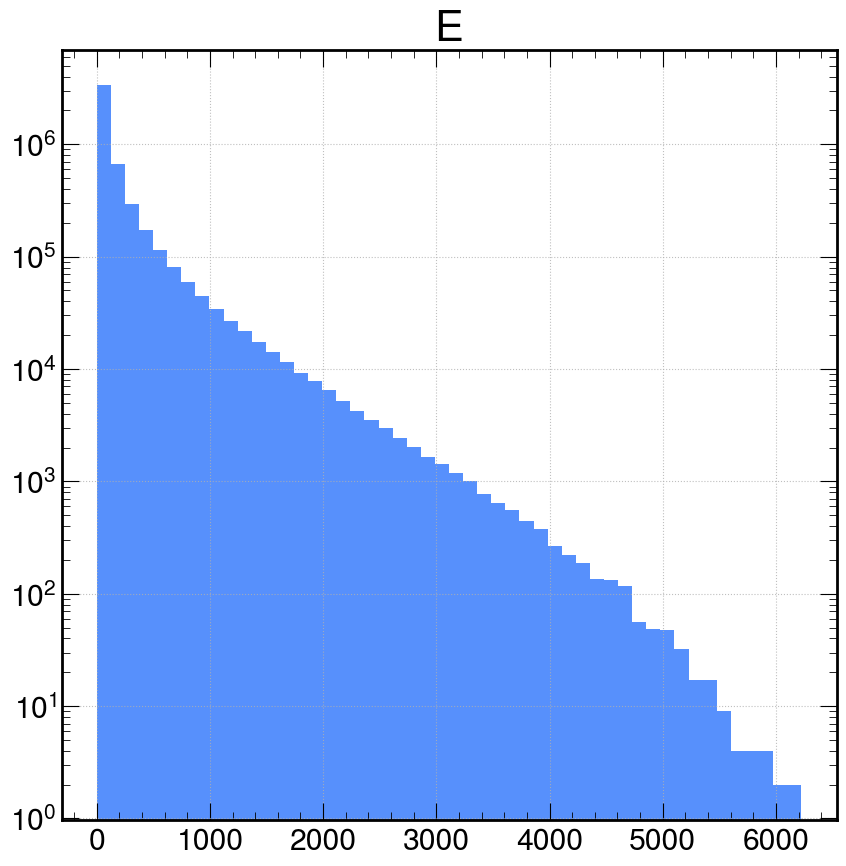

In [34]:
df_events.hist('E', bins=50, log=True)